# Transformer Model for Crypto Price Prediction

**Target**: Predicting whether the crypto price will be higher in 5 days than it is today  
**Method**: Transformer - Self-Attention Neural Network with TensorFlow/Keras

## What is a Transformer?
- **Self-Attention Mechanism**: Learns which past timesteps are most important for prediction
- **Parallel Processing**: Unlike LSTM/GRU, processes all timesteps simultaneously (faster!)
- **Long-range Dependencies**: Can directly connect Day 1 to Day 20 (no vanishing gradient)
- **Multi-Head Attention**: Multiple attention patterns learn different temporal relationships
- **State-of-the-art**: Currently dominates NLP, increasingly used for time series
- **Interpretable**: Can visualize which past days the model focuses on

## Transformer vs LSTM/GRU:
| Feature | LSTM/GRU | Transformer |
|---------|----------|-------------|
| **Processing** | Sequential (slow) | Parallel (fast) |
| **Memory** | Hidden state (limited) | Self-attention (unlimited) |
| **Long-term** | Vanishing gradient issue | Direct attention |
| **Parameters** | ~35K | ~100K+ |
| **Interpretability** | Black box | Attention weights visible |

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random
import datetime
import time
from pathlib import Path

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Random seeds for reproducibility
SEED = 101
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Keras layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D
)

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f"TensorFlow {tf.__version__}")

TensorFlow 2.19.0


In [2]:
# Load data
df_transformer = pd.read_csv("/Users/ina/Documents/spicedAcademy/time_series_project/data/final_data/20251115_dataset_crp.csv")

print(f"Loaded {df_transformer.shape[0]:,} rows, {df_transformer.shape[1]} columns")
print(f"Cryptocurrencies: {df_transformer['ticker'].nunique()}")

Loaded 200,973 rows, 78 columns
Cryptocurrencies: 142


In [3]:
# Train-Validation-Test Split (70%-15%-15% temporal split)
split_date_train = "2024-07-01"  # Training until this date
split_date_val = "2024-10-01"    # Validation from here
split_date_test = "2025-01-01"   # Testing from here

df_train = df_transformer[df_transformer['date'] < split_date_train].copy()
df_val = df_transformer[(df_transformer['date'] >= split_date_train) & (df_transformer['date'] < split_date_val)].copy()
df_test = df_transformer[df_transformer['date'] >= split_date_test].copy()

print(f"\nTraining set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")
print(f"Test set: {len(df_test)} samples")
print(f"Train up to date: {df_train['date'].max()}")
print(f"Validation from date: {df_val['date'].min()} to {df_val['date'].max()}")
print(f"Test from date: {df_test['date'].min()}")


Training set: 142034 samples
Validation set: 9543 samples
Test set: 39328 samples
Train up to date: 2024-06-30 00:00:00+00:00
Validation from date: 2024-07-01 00:00:00+00:00 to 2024-09-30 00:00:00+00:00
Test from date: 2025-01-01 00:00:00+00:00


In [4]:
# Prepare features and targets

# Target columns to exclude
target_columns = [
    'future_5_close_higher_than_today',
    'future_10_close_higher_than_today',
    'future_5_close_lower_than_today',
    'future_10_close_lower_than_today',
    'higher_close_today_vs_future_5_close',
    'higher_close_today_vs_future_10_close',
    'lower_close_today_vs_future_5_close',
    'lower_close_today_vs_future_10_close'
]

# Get feature columns
feature_columns = []
for col in df_train.columns:
    if col not in target_columns:
        feature_columns.append(col)

# Split features and target
X_train = df_train[feature_columns].copy()
y_train = df_train["future_5_close_higher_than_today"].values

X_val = df_val[feature_columns].copy()
y_val = df_val["future_5_close_higher_than_today"].values

X_test = df_test[feature_columns].copy()
y_test = df_test["future_5_close_higher_than_today"].values

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Columns to scale (exclude ticker and date)
columns_to_scale = []
for col in X_train.columns:
    if col not in ['ticker', 'date']:
        columns_to_scale.append(col)

# Fit and transform
X_train_scaled_vals = scaler_X.fit_transform(X_train[columns_to_scale])
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

X_val_scaled_vals = scaler_X.transform(X_val[columns_to_scale])
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

X_test_scaled_vals = scaler_X.transform(X_test[columns_to_scale])
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print(f"✅ Features: {X_train_scaled_vals.shape}, Target: {y_train_scaled.shape}")

✅ Features: (142034, 68), Target: (142034,)


In [5]:
# Create sequences for transformer
look_back = 20

# Training sequences
X_train_sequences = []
y_train_sequences = []
train_row_indices = []

for crypto in X_train['ticker'].unique():
    # Get data for this crypto
    is_this_crypto = X_train['ticker'] == crypto
    crypto_features = X_train_scaled_vals[is_this_crypto]
    crypto_targets = y_train_scaled[is_this_crypto]
    crypto_dates = X_train.loc[is_this_crypto, 'date'].values
    crypto_rows = X_train[is_this_crypto].index.values
    
    # Sort by date
    date_order = np.argsort(crypto_dates)
    crypto_features = crypto_features[date_order]
    crypto_targets = crypto_targets[date_order]
    crypto_rows = crypto_rows[date_order]
    
    # Create sliding windows
    num_sequences = len(crypto_features) - look_back
    for i in range(num_sequences):
        sequence = crypto_features[i : i + look_back]
        target = crypto_targets[i + look_back]
        row = crypto_rows[i + look_back]
        
        X_train_sequences.append(sequence)
        y_train_sequences.append(target)
        train_row_indices.append(row)

# Convert to arrays
X_train_seq = np.array(X_train_sequences)
y_train_seq = np.array(y_train_sequences)
train_indices = np.array(train_row_indices)

# Validation sequences
X_val_sequences = []
y_val_sequences = []
val_row_indices = []

for crypto in X_val['ticker'].unique():
    is_this_crypto = X_val['ticker'] == crypto
    crypto_features = X_val_scaled_vals[is_this_crypto]
    crypto_targets = y_val_scaled[is_this_crypto]
    crypto_dates = X_val.loc[is_this_crypto, 'date'].values
    crypto_rows = X_val[is_this_crypto].index.values
    
    date_order = np.argsort(crypto_dates)
    crypto_features = crypto_features[date_order]
    crypto_targets = crypto_targets[date_order]
    crypto_rows = crypto_rows[date_order]
    
    num_sequences = len(crypto_features) - look_back
    for i in range(num_sequences):
        sequence = crypto_features[i : i + look_back]
        target = crypto_targets[i + look_back]
        row = crypto_rows[i + look_back]
        
        X_val_sequences.append(sequence)
        y_val_sequences.append(target)
        val_row_indices.append(row)

X_val_seq = np.array(X_val_sequences)
y_val_seq = np.array(y_val_sequences)
val_indices = np.array(val_row_indices)

# Test sequences
X_test_sequences = []
y_test_sequences = []
test_row_indices = []

for crypto in X_test['ticker'].unique():
    is_this_crypto = X_test['ticker'] == crypto
    crypto_features = X_test_scaled_vals[is_this_crypto]
    crypto_targets = y_test_scaled[is_this_crypto]
    crypto_dates = X_test.loc[is_this_crypto, 'date'].values
    crypto_rows = X_test[is_this_crypto].index.values
    
    date_order = np.argsort(crypto_dates)
    crypto_features = crypto_features[date_order]
    crypto_targets = crypto_targets[date_order]
    crypto_rows = crypto_rows[date_order]
    
    num_sequences = len(crypto_features) - look_back
    for i in range(num_sequences):
        sequence = crypto_features[i : i + look_back]
        target = crypto_targets[i + look_back]
        row = crypto_rows[i + look_back]
        
        X_test_sequences.append(sequence)
        y_test_sequences.append(target)
        test_row_indices.append(row)

X_test_seq = np.array(X_test_sequences)
y_test_seq = np.array(y_test_sequences)
test_indices = np.array(test_row_indices)

# Get number of features
n_features = X_train_seq.shape[2]

print(f"Shape after creating squences: {X_train_seq.shape}")

Shape after creating squences: (139766, 20, 68)


In [6]:
# Positional encoding: transformers process all timesteps in parallel
# We need to give each day a unique position identifier

# How many days and features?
num_days = 20
num_features = 68

# Create position numbers [0, 1, 2, ..., 19]
position_numbers = np.arange(num_days)
position_numbers = position_numbers[:, np.newaxis]  # Reshape to column

# Create frequency values (formula from research paper)
even_numbers = np.arange(0, num_features, 2)
frequencies = np.exp(even_numbers * -(np.log(10000.0) / num_features))

# Create empty table: 20 rows × 68 columns
position_encoding_table = np.zeros((num_days, num_features))

# Fill with sine/cosine patterns
position_encoding_table[:, 0::2] = np.sin(position_numbers * frequencies)  # Even columns
position_encoding_table[:, 1::2] = np.cos(position_numbers * frequencies)  # Odd columns

# Convert to TensorFlow format
positional_encoding = tf.constant(position_encoding_table, dtype=tf.float32)

print(f"Positional encoding shape: {positional_encoding.shape}")

Positional encoding shape: (20, 68)


In [7]:
# Transformer settings
head_size = 128
num_heads = 4
dropout_rate = 0.2
ff_dim = 128

In [8]:
# Build transformer model
learning_rate = 0.0001
mlp_dropout = 0.3

# Input layer
inputs = Input(shape=(look_back, n_features))

# Add positional encoding
x = inputs + positional_encoding

# Transformer Block 1
# Multi-head attention
attention_1 = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(x, x)
attention_1 = Dropout(dropout_rate)(attention_1)

# Residual connection
attention_1 = x + attention_1
attention_1 = LayerNormalization(epsilon=1e-6)(attention_1)

# Feed-forward network
ffn_1 = Dense(ff_dim, activation="relu")(attention_1)
ffn_1 = Dropout(dropout_rate)(ffn_1)
ffn_1 = Dense(n_features)(ffn_1)
ffn_1 = Dropout(dropout_rate)(ffn_1)

# Residual connection
ffn_1 = attention_1 + ffn_1
block_1_output = LayerNormalization(epsilon=1e-6)(ffn_1)

# Transformer Block 2
# Multi-head attention
attention_2 = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(block_1_output, block_1_output)
attention_2 = Dropout(dropout_rate)(attention_2)

# Residual connection
attention_2 = block_1_output + attention_2
attention_2 = LayerNormalization(epsilon=1e-6)(attention_2)

# Feed-forward network
ffn_2 = Dense(ff_dim, activation="relu")(attention_2)
ffn_2 = Dropout(dropout_rate)(ffn_2)
ffn_2 = Dense(n_features)(ffn_2)
ffn_2 = Dropout(dropout_rate)(ffn_2)

# Residual connection
ffn_2 = attention_2 + ffn_2
block_2_output = LayerNormalization(epsilon=1e-6)(ffn_2)

# Pool across time dimension
pooled = GlobalAveragePooling1D()(block_2_output)

# Final prediction layers
prediction = Dense(64, activation="relu")(pooled)
prediction = Dropout(mlp_dropout)(prediction)
outputs = Dense(1, activation="linear")(prediction)

# Create model
model_transformer = Model(inputs=inputs, outputs=outputs)

# Compile model
model_transformer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="mae",
    metrics=["mae", "mse"]
)
model_transformer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 68)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 68)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 68)    │    140,868 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 68)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 68)    │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 68)    │        136 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 128)   │      8,832 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20, 68)    │      8,772 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 20, 68)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 20, 68)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 68)    │        136 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 68)    │    140,868 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 20, 68)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 20, 68)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 68)    │        136 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20, 128)   │      8,832 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 20, 128)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 20, 68)    │      8,772 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 20, 68)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 321,969 (1.23 MB)

 Trainable params: 321,969 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train transformer model
epochs = 100
batch_size = 128
patience = 15

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate if stuck
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train
history = model_transformer.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 116s 104ms/step - loss: 0.7423 - mae: 0.7423 - mse: 1.0277 - val_loss: 0.7147 - val_mae: 0.7147 - val_mse: 0.8853 - learning_rate: 1.0000e-04
Epoch 2/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 137s 125ms/step - loss: 0.6981 - mae: 0.6981 - mse: 0.9250 - val_loss: 0.7194 - val_mae: 0.7194 - val_mse: 0.9114 - learning_rate: 1.0000e-04
Epoch 3/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 116s 106ms/step - loss: 0.6780 - mae: 0.6780 - mse: 0.8851 - val_loss: 0.7750 - val_mae: 0.7750 - val_mse: 1.0366 - learning_rate: 1.0000e-04
Epoch 4/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 95s 87ms/step - loss: 0.6597 - mae: 0.6597 - mse: 0.8496 - val_loss: 0.7837 - val_mae: 0.7837 - val_mse: 1.0531 - learning_rate: 1.0000e-04
Epoch 5/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 97s 89ms/step - loss: 0.6444 - mae: 0.6444 - mse: 0.8182 - val_loss: 0.7805 - val_mae: 0.7805 - val_mse: 1.0479 - learning_rate: 1.0000e-04
Epoch 6/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.6328 - mae: 0

In [10]:
# Training metrics from the last epoch
mae_train = history.history['mae'][-1]
mse_train = history.history['mse'][-1]
print("Train Set Performance:")
print(f"   MAE:  {mae_train:.4f}")
print(f"   MSE:  {mse_train:.4f}")

val_mae = history.history['val_mae'][-1]
val_mse = history.history['val_mse'][-1]
print("\nValidation Set Performance:")
print(f"   MAE:  {val_mae:.4f}")
print(f"   MSE:  {val_mse:.4f}")

Train Set Performance:
   MAE:  0.5897
   MSE:  0.7109

Validation Set Performance:
   MAE:  0.8626
   MSE:  1.2000


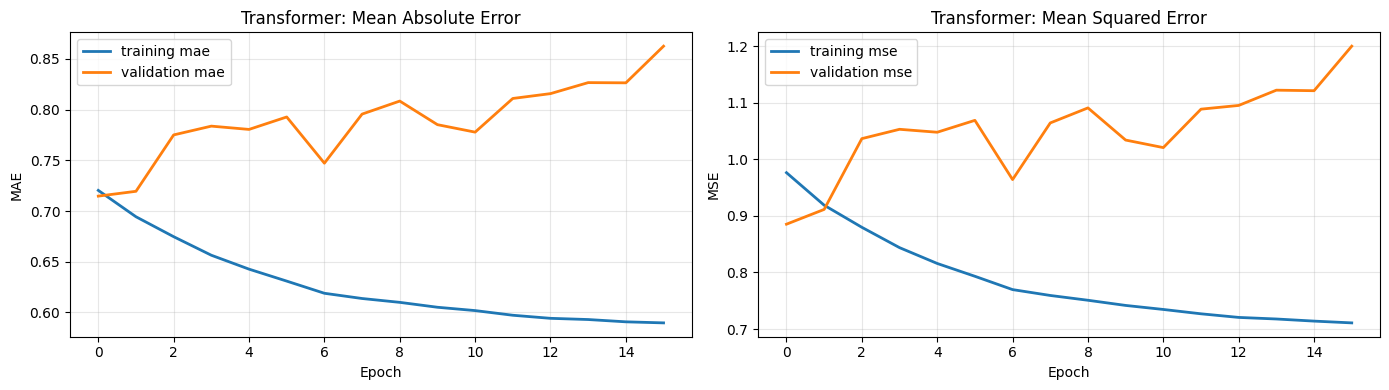

In [11]:
# Visualize training history - Transformer
fig, axes = plt.subplots(1, 2, figsize=(14,4))

# MAE
axes[0].plot(history.history['mae'], label='training mae', linewidth=2)
axes[0].plot(history.history['val_mae'], label='validation mae', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].set_title('Transformer: Mean Absolute Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MSE
axes[1].plot(history.history['mse'], label='training mse', linewidth=2)
axes[1].plot(history.history['val_mse'], label='validation mse', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE')
axes[1].set_title('Transformer: Mean Squared Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Evaluate model on test set
y_pred_scaled = model_transformer.predict(X_test_seq)

# Metrics on scaled data
mae = mean_absolute_error(y_test_seq, y_pred_scaled)
mse = mean_squared_error(y_test_seq, y_pred_scaled)

print("Test Set Performance (Scaled Data):")
print(f"   MAE:  {mae:.4f}")
print(f"   MSE:  {mse:.4f}")

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
Test Set Performance (Scaled Data):
   MAE:  0.7381
   MSE:  0.9770


In [13]:
# INVERSE TRANSFORM - Convert predictions back to original scale

# Inverse transform predictions
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Get actual original values using the tracked indices
y_test_original = df_test.loc[test_indices, 'future_5_close_higher_than_today'].values

# Calculate metrics on ORIGINAL scale
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)

print("Test Set Performance (Original Scale):")
print(f"   MAE:  {mae:.4f} percentage points")
print(f"   MSE:  {mse:.4f}")
print(f"\nNote: {len(y_pred_original)} predictions aligned with original data using indices")

Test Set Performance (Original Scale):
   MAE:  8.3834 percentage points
   MSE:  126.0466

Note: 36638 predictions aligned with original data using indices


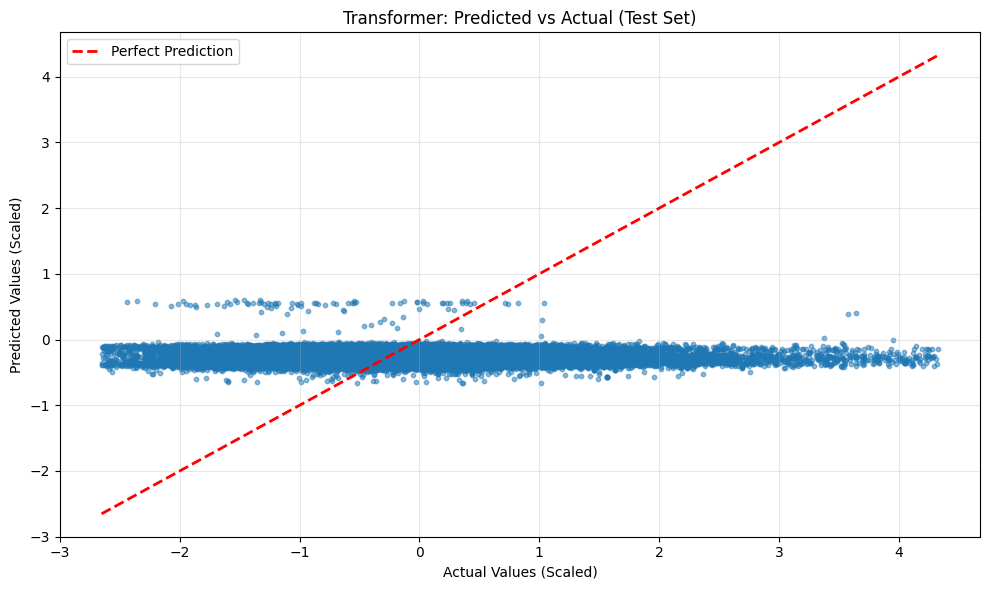

In [14]:
# Visualize: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_seq, y_pred_scaled, alpha=0.5, s=10)
plt.plot([y_test_seq.min(), y_test_seq.max()], 
         [y_test_seq.min(), y_test_seq.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values (Scaled)')
plt.ylabel('Predicted Values (Scaled)')
plt.title('Transformer: Predicted vs Actual (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

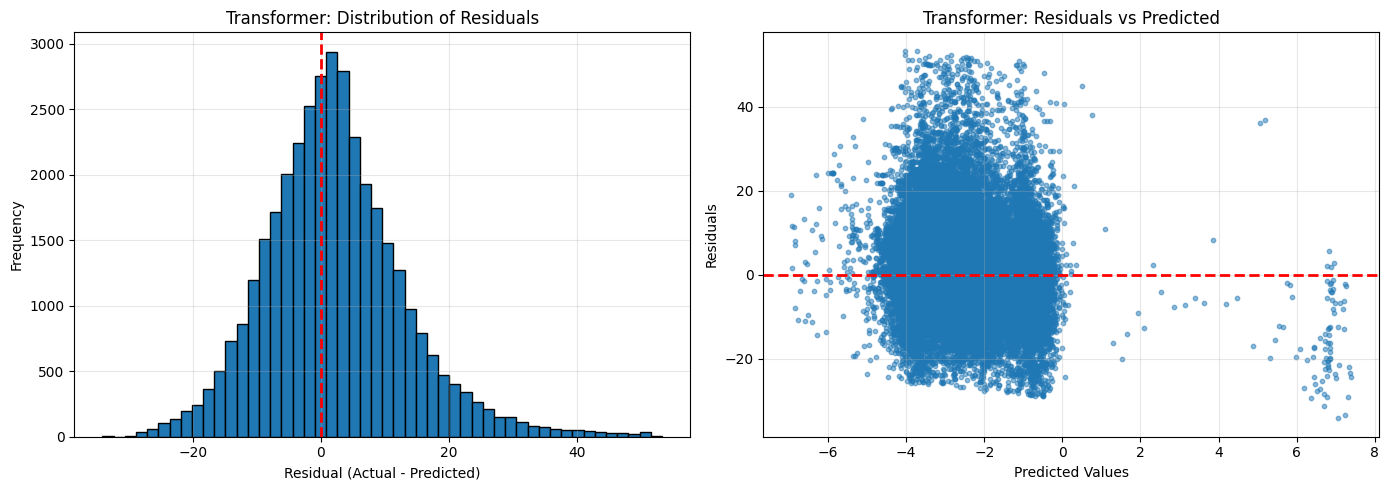

Residual Stats:
   Mean: 2.1799
   Std:  11.0134
   Min:  -34.1656
   Max:  53.3104


In [15]:
# Visualize: Residuals Analysis - Transformer
residuals = y_test_original - y_pred_original

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals histogram
axes[0].hist(residuals, bins=50, edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Transformer: Distribution of Residuals')
axes[0].grid(True, alpha=0.3)

# Residuals vs Predicted
axes[1].scatter(y_pred_original, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Transformer: Residuals vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Stats:")
print(f"   Mean: {residuals.mean():.4f}")
print(f"   Std:  {residuals.std():.4f}")
print(f"   Min:  {residuals.min():.4f}")
print(f"   Max:  {residuals.max():.4f}")

In [16]:
model_transformer.save('/Users/ina/Documents/spicedAcademy/time_series_project//models/model_transformer.keras')